In [5]:
import numpy as np
import cv2 as cv
img = cv.imread('Corn_Common_Rust (20).jpg')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [3]:
print(ret,"OP", thresh)

127.0 OP [[  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [6]:
cv.drawContours(img, contours, -1, (0,255,0), 3)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[ 58, 133, 117],
        [ 58, 133, 117],
        [ 57, 135, 118],
        ...,
        [ 50,  83,  69],
        [ 47,  82,  68],
        [ 46,  81,  67]],

       [[ 57, 132, 116],
        [ 57, 132, 116],
        [ 56, 135, 116],
        ...,
        [ 47,  82,  68],
        [ 46,  80,  69],
        [ 46,  80,  69]],

       [[ 56, 131, 115],
        [ 57, 132, 116],
        [ 56, 135, 116],
        ...,
        [ 46,  81,  67],
        [ 45,  79,  68],
        [ 45,  79,  68]]

In [7]:
cnt = contours[4]
cv.drawContours(img, [cnt], 0, (0,255,0), 3)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[ 58, 133, 117],
        [ 58, 133, 117],
        [ 57, 135, 118],
        ...,
        [ 50,  83,  69],
        [ 47,  82,  68],
        [ 46,  81,  67]],

       [[ 57, 132, 116],
        [ 57, 132, 116],
        [ 56, 135, 116],
        ...,
        [ 47,  82,  68],
        [ 46,  80,  69],
        [ 46,  80,  69]],

       [[ 56, 131, 115],
        [ 57, 132, 116],
        [ 56, 135, 116],
        ...,
        [ 46,  81,  67],
        [ 45,  79,  68],
        [ 45,  79,  68]]

OKAY


In [9]:
import tensorflow as tf

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [10]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

In [11]:

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [12]:

OUTPUT_CHANNELS = 3

def unet():
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))
  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet()

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)         

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

NameError: name 'train_dataset' is not defined

KILL MY SELF PLEASE OPENCV :_: :(((((((((((((((

In [1]:
import cv2
import numpy as np

img = cv2.imread('C:/Users/aaaya/Desktop/Workspace/Mini-Project(Github)/Maize-Disease-detection/MiniProject/dataset/test/Corn_Blight (48).jpg')
print(img.shape)


paintboard = np.zeros(img.shape, np.uint8)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


ret,thresh = cv2.threshold(img_gray, 127,255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

cv2.drawContours(paintboard, contours, -1, (0,255,0), 1)

cv2.imshow('CONTOUR',paintboard)
# cv2.imshow('THRESHOLD',thresh)
# cv2.imshow('ORIGINAL',img)

cv2.waitKey(0)
cv2.destroyAllWindows()

(300, 300, 3)


In [14]:
selection = np.zeros_like(img)
selection[thresh] - img[contours]

cv2.imshow('OK',selection)

cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:124: error: (-215:Assertion failed) bmi && width >= 0 && height >= 0 && (bpp == 8 || bpp == 24 || bpp == 32) in function 'FillBitmapInfo'


I BEG OPENCV

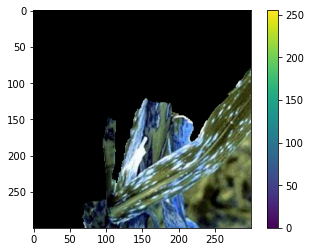

(<matplotlib.image.AxesImage at 0x2e4308fa020>,
 None)

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('C:/Users/aaaya/Desktop/Workspace/Mini-Project(Github)/Maize-Disease-detection/MiniProject/dataset/test/Corn_Blight (48).jpg')
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

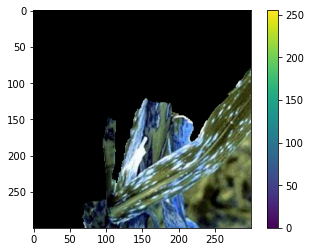

(<matplotlib.image.AxesImage at 0x2e432a6ea10>,
 None)

In [3]:
# newmask is the mask image I manually labelled
newmask = cv.imread('newmask.png',0)
# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1
mask, bgdModel, fgdModel = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()